# Collaborative-based recommender system using Graph Neural Networks

Recommender systems are everywhere: on major platforms like Amazon, Netflix, and Spotify, offering suggestions that range from fantastic to underwhelming, and sometimes even amusing. While they make it easier for us to discover new things to buy, watch, or listen to, it's the companies that gain the most from their use.

Recommender systems primarily use two approaches: content-based filtering and collaborative filtering.

- **Content-Based Filtering**:
This approach recommends items by analyzing the features of the items themselves (e.g., genre, brand) and matching them to a user’s preferences or past interactions. It suggests items similar to those the user has previously engaged with, focusing on item characteristics rather than other users’ behaviors.

- **Collaborative Filtering**:
Collaborative filtering generates recommendations by leveraging user behavior. It identifies patterns based on how users interact with items and makes recommendations either by finding similar users (user-based) or by finding similar items based on user preferences (item-based). It relies on the assumption that users with similar past behavior will like similar items.

Both methods are essential in building personalized recommendation systems, and they are often combined for better results.

In this tutorial, we use the "Collaborative Filtering" approach to implement a "book recommender system". 

To implement a book recommender system, we use the Book-Crossing dataset which contains book ratings from 278,858 users of the BookCrossing community (www.bookcrossing.com). These ratings are explicit feedback (ratings from 1 to 10), totaling 1,149,780 ratings across 271,379 books. The dataset was gathered by Cai-Nicolas Ziegler during a four-week data collection in August and September 2004. We will utilize the Book-Crossing dataset to develop a book recommendation system.


The dataset consists of three files, which we will load sequentially as tabular data.

- First, the user-rating file contains explicit feedback, where each entry associates a user ID with a specific book identified by its ISBN. Most of the ratings are zero.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv
import tqdm as notebook_tqdm

K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')
df.head()


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


- Second file is the user attribute file, which contains the age and location of each user.

In [10]:
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


- Third file is the item (book) attribute file, containing features for each book such as the title, author, year of publication, and more.

In [11]:
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
books.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_2564\2192118833.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


The next step is to build an **undirected, unweighted, bipartite** graph based on the user-book interaction:

- A **bipartite** graph is a graph where the set of nodes can be divided into two distinct groups, such that no two nodes within the same group are connected by an edge. All edges only link nodes from one group to nodes in the other group. 
A user-item graph is well-modeled by a bipartite graph because users and items naturally form two distinct sets. In this graph, edges represent interactions (e.g., purchases, ratings) between users and items, with no connections between nodes within the same set (e.g., no user-user or item-item edges), aligning perfectly with the structure of a bipartite graph.

<center><img src="images/user_item.png" width="300"/></center>

- The graph is undirected and **unweighted**, with *an edge placed between a user and a corresponding book only if the rating is above eight*. 
In this graph, each edge represents a significant user-book interaction based on ratings. Specifically, an edge is added between a user and a book only when the user has given a rating higher than eight, indicating a strong preference. The graph is undirected, meaning the relationship is mutual (the user is connected to the book, and vice versa), and unweighted, so all connections are treated equally, regardless of how much the rating exceeds eight. This simplifies the model by focusing only on high ratings, disregarding the exact rating value above this threshold.

In [12]:
# Preprocessing: filtering user-book interactions to only include valid users and books found in related datasets "books" & "users"
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k high ratings for faster computation and training
df = df[df['Book-Rating'] >= 8].iloc[:100000]

# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i]+num_users for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

Next, we split the edges into 80% train, 10% validation and 10% test.

In [13]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

Now, we build a simple GCN network to compute the embeddings of the users/items based on the graph structure. Specifically, we use LightGCN (available in PYG). In LGC, only the normalized sum of neighbor embeddings is performed towards next layer; other operations like self-connection, feature transformation, and nonlinear activation are all removed, which largely simplifies GCNs.

The graph convolution operation (propagation rule) in LightGCN is defined as:

\begin{equation*}
x_i^{(k+1)} = \sum_{j \in \mathcal{N}_i}  \frac{1}{\sqrt(|\mathcal{N}_j|)\sqrt(|\mathcal{N}_i|)} x_j^{(k)}
\end{equation*}

It is worth emphasizing that in LightGCN, we aggregate only the connected neighbors and do not integrate the target node itself (i.e., we don't have selfconnection).

We use LightGCN to design the following architecture for the link prediction problem:

<center>
<img src="images/LGCN.png" width="600"/>
</center>

Note that in the bipartite graph, "user" nodes are only connected to "item" nodes and vice versa; there are no connections between users or between items themselves. In this figure, $e_{i_1}^{(l-1)}$ represents the embedding for the $i_1$-th node in the $(l-1)$-th layer.

>Important!! 
The only trainable model parameters are the embeddings at the 0-th layer, i.e., $e_u^{(0)}$ for all users and $e_i^{(0)}$ for all items.

When the initial embeddings are given, the embeddings at higher layers can be computed via LightGCN formula given above. After $K$ layers (in the figure, $K=3$), we combine the embeddings obtained at each layer to form the final representation of a user (an item):

\begin{equation*}
e_u = \sum_{k=0}^K e_u^{(k)}; \quad e_i =\sum_{k=0}^K e_i^{(k)}
\end{equation*}

Note how we combined the initial embedding as well. This layer combination operation, captures the same effect as self-connections.

Finally! The model prediction is defined as the inner product of user and item final representations:

\begin{equation*}
\hat{y}_{ui}=e_u^\top e_i,
\end{equation*}

which is used as the ranking score for recommendation generation.



In [14]:
import torch
from tqdm import tqdm
from torch_geometric.nn import LightGCN
from torch_geometric.utils import degree
import pandas as pd
import matplotlib.pyplot as plt 
import torch

K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


batch_size = 8000
train_loader = torch.utils.data.DataLoader(
    range(len(train_index)),
    shuffle=True,
    batch_size=batch_size,
)

model = LightGCN(
    num_nodes=num_total,
    embedding_dim=64,
    num_layers=3,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    total_loss = total_examples = 0

    for index in tqdm(train_loader):
        # Sample positive and negative labels.
        pos_edge_label_index = train_edge_index[:, index]
        neg_edge_label_index = torch.stack([
            pos_edge_label_index[0],
            torch.randint(num_users, num_users + num_items,
                          (index.numel(), ), device=device)
        ], dim=0)
        edge_label_index = torch.cat([
            pos_edge_label_index,
            neg_edge_label_index,
        ], dim=1)

        optimizer.zero_grad()
        pos_rank, neg_rank = model(edge_index, edge_label_index).chunk(2)

        loss = model.recommendation_loss(
            pos_rank,
            neg_rank,
            node_id=edge_label_index.unique(),
        )
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * pos_rank.numel()
        total_examples += pos_rank.numel()

    return total_loss / total_examples


@torch.no_grad()
def test(k: int):
    emb = model.get_embedding(edge_index)
    user_emb, book_emb = emb[:num_users], emb[num_users:]

    precision = recall = total_examples = 0

    logits = user_emb @ book_emb.t()

    # Exclude training edges:
    logits[train_edge_index[0],
            train_edge_index[1] - num_users] = float('-inf')

    # Computing precision and recall:
    ground_truth = torch.zeros_like(logits, dtype=torch.bool)
    ground_truth[test_edge_index[0],
                    test_edge_index[1] - num_users] = True
    node_count = degree(test_edge_index[0],
                        num_nodes=logits.size(0))

    topk_index = logits.topk(k, dim=-1).indices
    isin_mat = ground_truth.gather(1, topk_index)

    precision += float((isin_mat.sum(dim=-1) / k).sum())
    recall += float((isin_mat.sum(dim=-1) / node_count.clamp(1e-6)).sum())
    total_examples += int((node_count > 0).sum())

    return precision / total_examples, recall / total_examples


for epoch in range(1, 101):
    loss = train()
    print(loss)
    precision, recall = test(k=20)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Precision@20: '
          f'{precision:.4f}, Recall@20: {recall:.4f}')

100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


0.6931476175785065
Epoch: 001, Loss: 0.6931, Precision@20: 0.0000, Recall@20: 0.0003


100%|██████████| 10/10 [00:01<00:00,  5.66it/s]


0.6931305944919586
Epoch: 002, Loss: 0.6931, Precision@20: 0.0001, Recall@20: 0.0011


100%|██████████| 10/10 [00:01<00:00,  5.58it/s]


0.6931033194065094
Epoch: 003, Loss: 0.6931, Precision@20: 0.0003, Recall@20: 0.0031


100%|██████████| 10/10 [00:01<00:00,  5.88it/s]


0.6930498242378235
Epoch: 004, Loss: 0.6930, Precision@20: 0.0006, Recall@20: 0.0067


100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


0.692952823638916
Epoch: 005, Loss: 0.6930, Precision@20: 0.0008, Recall@20: 0.0087


100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


0.6927938044071198
Epoch: 006, Loss: 0.6928, Precision@20: 0.0010, Recall@20: 0.0109


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


0.6925525724887848
Epoch: 007, Loss: 0.6926, Precision@20: 0.0011, Recall@20: 0.0126


 30%|███       | 3/10 [00:00<00:01,  4.61it/s]

In [7]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item() - num_users
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

user_pos_items = get_user_items(edge_index)

Favorite books from user n°277427:
- Into the Wild, by Jon Krakauer
- A Simple Plan, by Scott Smith
- The Once and Future King, by T. H. White
- Its Obvious You Wont Survive By Your Wit, by Scott Adams
- Chicks in Chainmail, by Esther Friesner

Recommended books for user n°277427
- The Street Lawyer, by JOHN GRISHAM
- A Prayer for Owen Meany, by John Irving
- Beloved, by Toni Morrison
- Life of Pi, by Yann Martel
- The Nanny Diaries: A Novel, by Emma McLaughlin


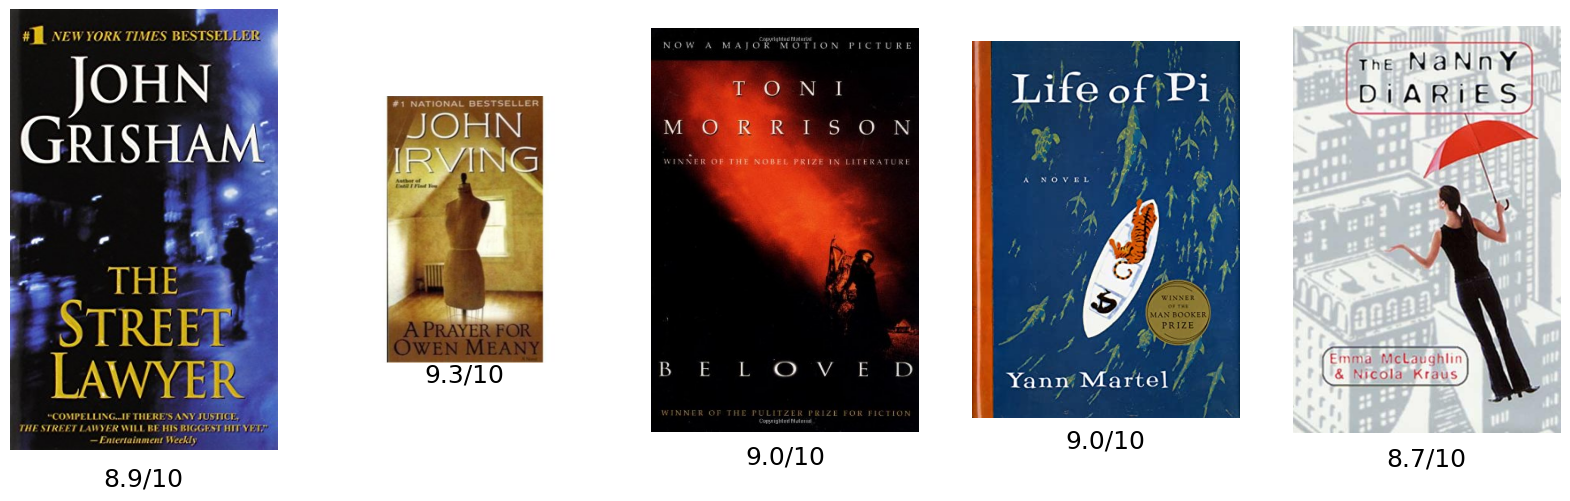

In [8]:
bookid_title = pd.Series(books['Book-Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Book-Author'].values, index=books.ISBN).to_dict()
from PIL import Image
import requests

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.embedding.weight[user]
    ratings = model.embedding.weight[num_users:] @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):
        url = books.loc[books['Book-Title'] == title]['Image-URL-L'][:1].values[0]
        img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = df.loc[df['ISBN'] == books.loc[books['Book-Title'] == title]['ISBN'][:1].values[0]]['Book-Rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)
recommend(277427, 5)